In [83]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten,Reshape
from keras.layers import Conv1D, MaxPooling1D
from keras.utils import np_utils
from keras.layers import LSTM, LeakyReLU, CuDNNLSTM
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
import h5py
import os
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
from keras import regularizers
import matplotlib.pyplot as plt

In [ ]:
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))

In [57]:
with h5py.File(''.join(['data/allcoin2015to2017_wf.h5']), 'r') as hf:
    test_inputs = hf['test_inputs'].value
    test_outputs = hf['test_outputs'].value
    test_input_times = hf['test_input_times'].value
    test_output_times = hf['test_output_times'].value
    original_test_inputs = hf['original_test_inputs'].value
    original_test_outputs = hf['original_test_outputs'].value
    original_datas= hf['original_datas'].value

In [14]:
step_size = test_inputs.shape[1]
units= 50
second_units = 30
batch_size = 8
nb_features = test_inputs.shape[2]
epochs = 50
output_size=1

In [17]:
model = Sequential()
model.add(CuDNNLSTM(units=units, input_shape=(step_size,nb_features),return_sequences=True))
model.add(Activation('tanh'))
model.add(Dropout(0.2))
model.add(MaxPooling1D(pool_size=16))
model.add(Dense(output_size))
model.add(LeakyReLU())
model.load_weights('weights/allcoin2015to2017_WF_LSTM_-21-09-0.85338.hdf5')
model.compile(loss='mse', optimizer='adam')

In [18]:
predicted = model.predict(test_inputs)

In [36]:
scaler = StandardScaler()
predicted_inverted = []
for i in range(len(original_datas)):
    scaler.fit(original_datas[i,:])
    predicted_inverted.append(scaler.inverse_transform(predicted[i,:]))
predicted_inverted = np.array(predicted_inverted)

In [90]:
ground_true_df = pd.DataFrame()
ground_true_df['times'] = pd.to_datetime(test_input_times[:,:,0].reshape(-1),unit='s')
ground_true_df['value'] = original_test_inputs[:,:,0].reshape(-1)
ground_true_df.set_index('times')
ground_true_df = ground_true_df.drop_duplicates(subset=['times','value'])
ground_true_df.head()

,times,value
0,2017-12-16 08:55:00,17860.000001
1,2017-12-16 09:00:00,17883.000000
2,2017-12-16 09:05:00,17823.282001
3,2017-12-16 09:10:00,17860.000000
4,2017-12-16 09:15:00,17846.900000


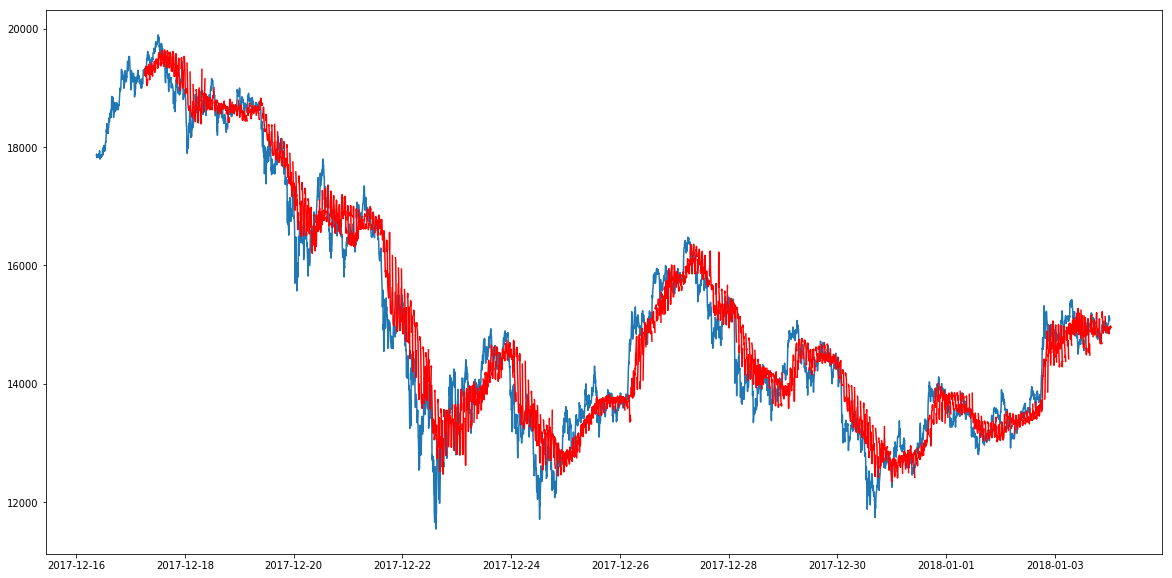

In [104]:
plt.figure(figsize=(20,10))
plt.plot(ground_true_df.times,ground_true_df.value, label = 'Actual')

for i in range(len(test_output_times)):
    if i%16 == 0:
        prediction_df = pd.DataFrame()
        prediction_df['times']= pd.to_datetime(test_output_times[i,:,:].reshape(-1),unit='s')
        prediction_df['value']= predicted_inverted[i,:,:].reshape(-1)
        plt.plot(prediction_df.times,prediction_df.value,'r', label='Predicted')
        
# plt.legend(loc='upper left')
# plt.savefig('result/bitcoin2015to2017_close_LSTM_1_tanh_leaky_result.png')
plt.show()


In [80]:
pd.to_datetime(test_output_times[i,:,:].reshape(-1),unit='s')

DatetimeIndex(['2017-12-17 06:15:00', '2017-12-17 06:20:00',
               '2017-12-17 06:25:00', '2017-12-17 06:30:00',
               '2017-12-17 06:35:00', '2017-12-17 06:40:00',
               '2017-12-17 06:45:00', '2017-12-17 06:50:00',
               '2017-12-17 06:55:00', '2017-12-17 07:00:00',
               '2017-12-17 07:05:00', '2017-12-17 07:10:00',
               '2017-12-17 07:15:00', '2017-12-17 07:20:00',
               '2017-12-17 07:25:00', '2017-12-17 07:30:00'],
              dtype='datetime64[ns]', freq=None)